In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples

gk = quadpy.c1.gauss_kronrod(40)

## Carregando dados

In [2]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './lc_fit_results_SALT2_HST_Pantheon.txt',
 './lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './lc_fit_results_SALT2_PS1_Pantheon.txt']

In [3]:
SDSS_fits=pd.read_csv("./lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [4]:
df_salt2_bf_cuts=pd.concat([SDSS_fits,SNLS_fits,PS1_fits,HST_fits,LOWZ_fits])

In [5]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<3.) & (abs(df_salt2_bf_cuts["X2/C"])<0.3)  & (df_salt2_bf_cuts["CHISQ/NDOF"]<5.)].reset_index(drop=True)

In [6]:
# corte nos erros: (df_salt2_bf_cuts["X1ERR"]-np.median(df_salt2_bf_cuts["X1ERR"])<np.std(df_salt2_bf_cuts["X1ERR"])) & (df_salt2_bf_cuts["X2/CERR"]-np.median(df_salt2_bf_cuts["X2/CERR"])<np.std(df_salt2_bf_cuts["X2/CERR"]))

In [7]:
SDSS_fits

,SNNAME,SURVEY,Z,ZERR,T0,T0ERR,X0,X0ERR,X1,X1ERR,...,X2/CERR,COV_X0_X1,COV_X0_X2/C,COV_X1_X2/C,CHISQ/NDOF,MODEL,mB,mBERR,COV_mB_X1,COV_mB_X2/C
0,744,SDSS,0.126940,0.0,53612.908167,0.780238,0.000215,0.000010,1.427003,0.323465,...,0.034334,3.026372e-08,-2.799295e-07,0.001043,0.753964,SALT2_ORI,19.805842,0.050297,-0.000153,0.001416
1,1112,SDSS,0.256085,0.0,53630.439303,1.050362,0.000044,0.000004,-0.263272,2.066752,...,0.069293,-5.761213e-06,-1.677454e-07,0.085132,0.387034,SALT2_ORI,21.528581,0.087718,0.142453,0.004148
2,1241,SDSS,0.088477,0.0,53635.363713,0.078874,0.000407,0.000011,-0.545725,0.079339,...,0.022815,-2.201143e-07,-2.009162e-07,0.000049,1.000397,SALT2_ORI,19.111577,0.029133,0.000587,0.000536
3,1371,SDSS,0.117969,0.0,53633.237783,0.106119,0.000428,0.000011,0.791268,0.097747,...,0.021699,-2.682227e-07,-1.839279e-07,0.000093,2.121200,SALT2_ORI,19.056020,0.027441,0.000680,0.000466
4,1580,SDSS,0.183217,0.0,53634.078113,0.217433,0.000139,0.000005,0.961702,0.245108,...,0.030969,-5.542497e-07,-1.149788e-07,0.000491,0.439818,SALT2_ORI,20.274510,0.038719,0.004318,0.000896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,20430,SDSS,0.162837,0.0,54420.031248,0.450380,0.000075,0.000003,5.496850,0.597480,...,0.044588,-1.090005e-06,-9.624180e-08,0.004386,2.133730,SALT2_ORI,20.947864,0.048541,0.015787,0.001394
327,20625,SDSS,0.106834,0.0,54423.605364,0.177563,0.000290,0.000008,-0.089044,0.206538,...,0.023579,-4.849470e-07,-1.515402e-07,0.001352,0.745795,SALT2_ORI,19.477929,0.029941,0.001814,0.000567
328,20764,SDSS,0.164775,0.0,54421.741616,0.424706,0.000141,0.000005,-1.201105,0.599984,...,0.031988,-1.065058e-06,-1.023442e-07,0.007536,1.318286,SALT2_ORI,20.258981,0.035850,0.008179,0.000786
329,21034,SDSS,0.107503,0.0,54426.059712,0.288075,0.000263,0.000007,0.046731,0.290981,...,0.023802,-2.362989e-07,-1.287401e-07,0.001605,0.925125,SALT2_ORI,19.586307,0.029198,0.000977,0.000532


## Visualizando distribuições e correlações

In [7]:
total_salt2=len(df_salt2_bf_cuts)
passcut_salt2_x1=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X1"])<=3])
passcut_salt2_c=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X2/C"])<=0.3])
passcut_salt2_chi2=len(df_salt2_bf_cuts[df_salt2_bf_cuts["CHISQ/NDOF"]<=5.])

De um total 1048 SNe, 1044 foram bem ajustadas.
16 não passaram no corte de |X1| < 3.
2 não passaram no corte de |C| < 0.3
12 não passaram no corte de Chi2 < 5.
No final ficamos com 1018 Sne.


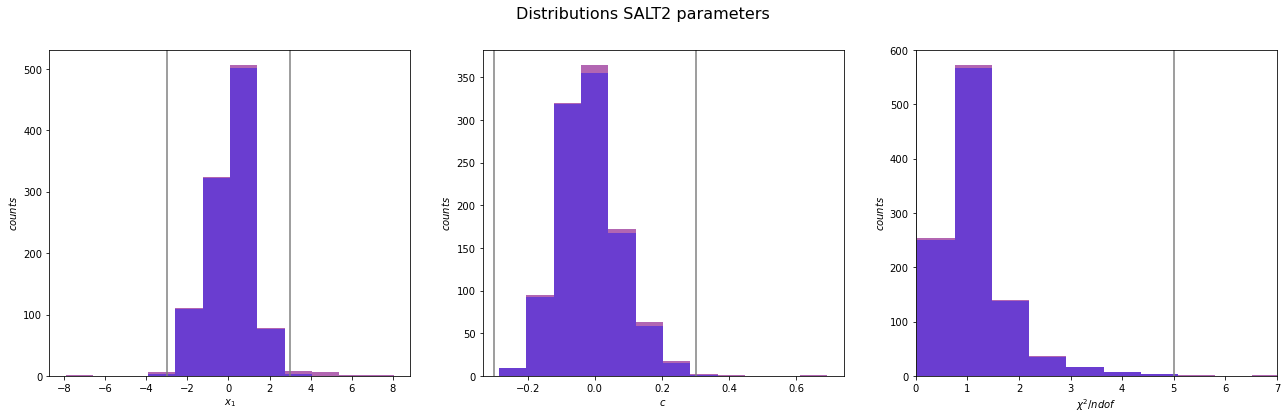

In [8]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Distributions SALT2 parameters",fontsize=16)

bins = 12
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],color="purple",bins=bins,alpha=0.6)
ax1.hist(df_salt2["X1"],color="blue",bins=bins,alpha=0.4)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$counts$")
ax1.axvline(3.,c="gray")
ax1.axvline(-3.,c="gray")

bins = 12
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,color="purple",alpha=0.6)
ax2.hist(df_salt2["X2/C"],color="blue",alpha=0.4,bins=bins)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel(r"$counts$")
ax2.axvline(0.3,c="gray")
ax2.axvline(-0.3,c="gray")

bins = 60
bins = np.histogram(np.hstack((df_salt2_bf_cuts["CHISQ/NDOF"], df_salt2["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_salt2_bf_cuts["CHISQ/NDOF"],bins=bins,color="purple",alpha=0.6)
ax3.hist(df_salt2["CHISQ/NDOF"],bins=bins,color="blue",alpha=0.4)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel(r"$counts$")
ax3.set_xlim(0,7)
ax3.axvline(0.,c="gray")
ax3.axvline(5.,c="gray")

print(f"De um total 1048 SNe, {total_salt2} foram bem ajustadas.")
print(f"{total_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{total_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"{total_salt2-passcut_salt2_chi2} não passaram no corte de Chi2 < 5.")
print(f"No final ficamos com {len(df_salt2)} Sne.")

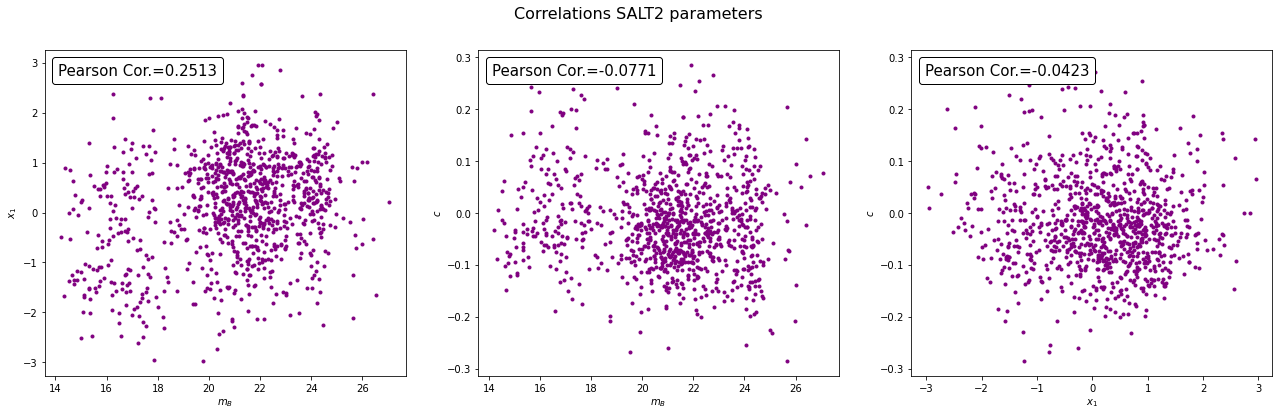

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Correlations SALT2 parameters",fontsize=16)

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="purple")
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="purple")
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$c$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="purple")
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$c$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);

## Ajustando LCDM

In [10]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def salt2_model(self,theta):
        Om, Ol, M, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
        
        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior(self, theta):
        Om, Ol, M, alpha, beta, sigma=theta     

        if not (0. < Om < 1. and -0.5 < Ol < 1.5 and 5. < M < 30. and -5. < alpha < 5. and -5. < beta < 5. and 0. < sigma < 5.):
            return -np.inf
        return 0. 
    
    def log_probability(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model(theta)

In [11]:
data=df_salt2[["Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C"]]

In [12]:
data.columns=["z","zerr","mB","mBerr","x1","x1err","c","cerr","cov_mB_x1","cov_mB_c","cov_x1_c"]

In [13]:
cosmo_salt2=cosmo(data)

In [15]:
cosmo_salt2.log_probability([0.3,0.7,24.,0.15,3.5,0.1])

157.92030174831433

In [16]:
pos = np.array([0.3,0.7,24.,0.1,3.5,0.1])+0.01 *np.random.randn(100, 6)
nwalkers, ndim = pos.shape

In [17]:
with Pool() as pool:
    sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability, pool=pool)
    sampler_salt2.run_mcmc(pos, 2000, progress=True)

100%|███████████████████████████████████████| 2000/2000 [03:16<00:00, 10.17it/s]


#### Chains SALT2

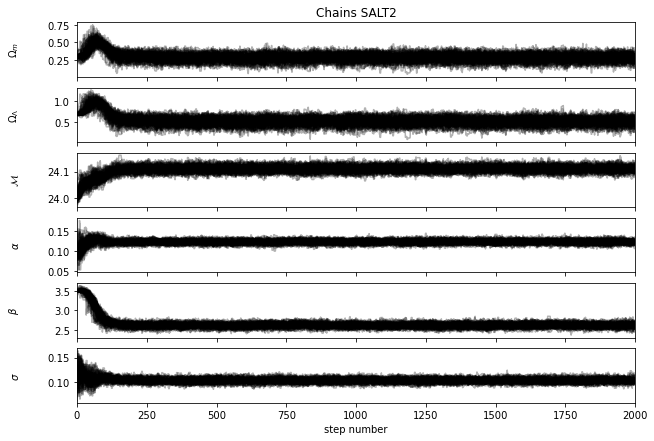

In [18]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2 = sampler_salt2.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [19]:
flat_samples_salt2 = sampler_salt2.get_chain(discard=1000, thin=15, flat=True) # oq esse thin significa?

In [20]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta",r"\sigma"]
names_gdist = ["Om","Ol","M","a","b","sig"]
samples_salt2 = MCSamples(samples=flat_samples_salt2, names=names_gdist, labels=labels_gdist, label=r'$\mathcal{L}, \sigma_{int}$ float')

Removed no burn in


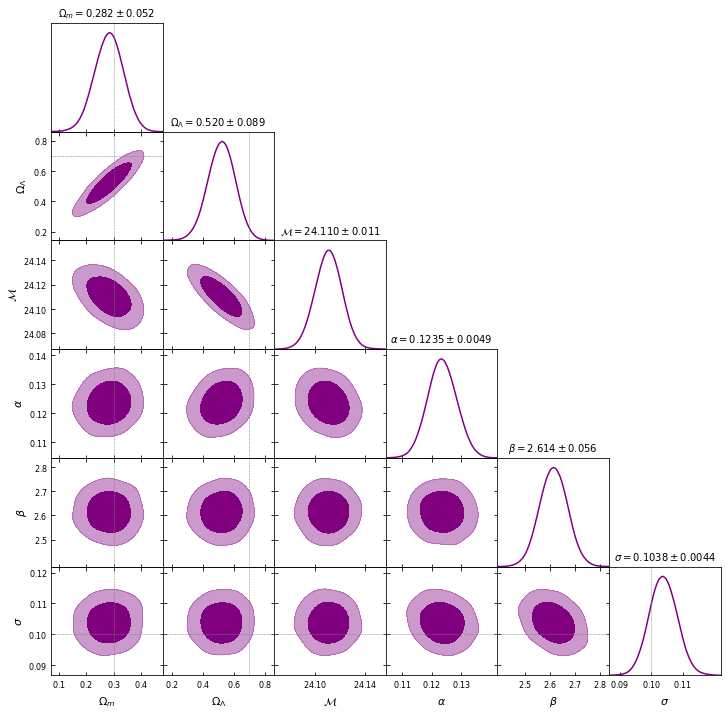

In [21]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot([samples_salt2], filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':3.,'sig':0.1})

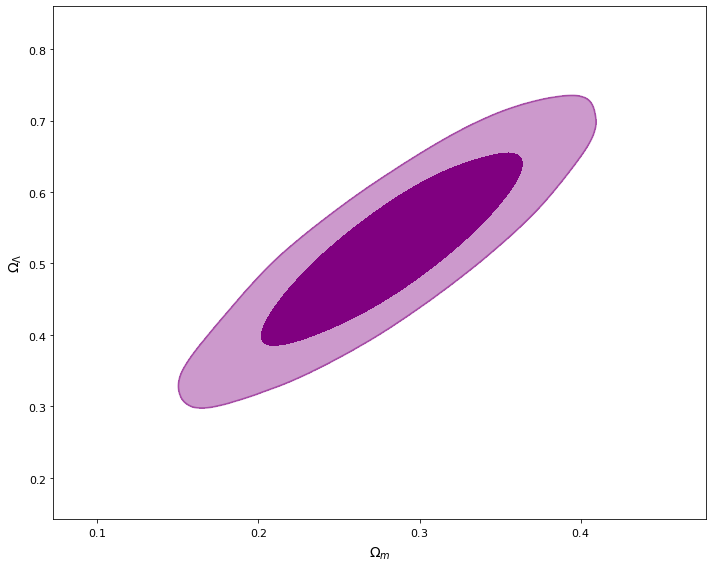

In [22]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2], 'Om', 'Ol', filled=True, colors=['purple']);